# Wong Wang Model

In [2]:
import numpy as np

import matplotlib.pyplot as plt

In [3]:
# Dynamical Equation Definitions
    
def F(I, a=270, b=108, d=0.154):
    '''
    rate [Hz] as a function of total input current [nA]
    '''
    return (a*I - b)/(1 - np.exp(-d*(a*I - b)))

In [4]:
def default_params( **kwargs):
    pars = {}
    
    ### gain variables ###
    pars['a'] = 270.   # Gain of the E population
    pars['b'] = 108.   # Threshold of the E population
    pars['d'] = 0.154
    
    ### synaptic parameters ###
    pars['tauS']  = 0.1   # Timescale of the E population [sec]
    pars['gamma'] = 0.641  # Saturation factor for gating variable 

    ### Connection strength ###
    pars['JE'] = 0.2609 # local self-coupling strength [nA]
    pars['JI'] = -0.0497 # local cross-coupling strength [nA]
    
    ### background input####
    pars['Ib1'] = 0.3255 # background current [nA]
    pars['Ib2'] = 0.3255 # background current [nA]
    ### OU background noise ###
    pars['tau0'] = 0.002 # Noise time constant [sec]
    pars['sigma'] = 0.02 # Noise magnitude [nA]
    pars['myseed'] = None

    ### simulation parameters ###
    pars['T']         = 5. # Total duration of simulation [sec]
    pars['dt']        = 0.0005 # Simulation time step [sec]
    pars['dt_smooth'] = 0.02 # Temporal window size for smoothing [sec]
    pars['s1_init'] = 0.0 # Initial value of s1, low hierarchy
    pars['s2_init'] = 0.0 # Initial value of s2, high hierarchy
    
    ### Stimulus Parameters ###
    pars['Jext'] = 5.2e-4 # Stimulus input strength [nA]
    pars['mu0']  = 30 #20.    # Strength of stimulus 1 [dimensionless]
    pars['coh'] = 0
    pars['Ntrials'] = 5   # Total number of trials
    pars['Tstim'] = 1.    # Time of stimulus 1 onset [sec]
    pars['Tdur'] = 2.     # Duration of stimulus 1 [sec]

    return pars

In [5]:
def run_sim(pars, verbose=False):
    '''
    Run simulation, for multiple trials.
    
    Parameters:
    pars : circuit model parameters
    
    Return: dictionary with activity traces
    '''
    # retivial parameters
    ### gain variables ###
    a, b, d = pars['a'], pars['b'], pars['d']
    
    ### synaptic parameters ###
    tauS, gamma = pars['tauS'], pars['gamma']

    ### Connection strength ###
    JE, JI = pars['JE'], pars['JI']
    
    ### background input####
    Ib1, Ib2 = pars['Ib1'], pars['Ib2']
    ### OU background noise ###
    tau0, sigma, myseed = pars['tau0'], pars['sigma'], pars['myseed']

    ### simulation parameters ###
    T, dt, dt_smooth = pars['T'], pars['dt'], pars['dt_smooth']
    s1_init, s2_init = pars['s1_init'], pars['s2_init']
    
    ### Stimulus Parameters ###
    Jext, mu1, mu2 = pars['Jext'], pars['mu1'], pars['mu2']
    Ntrials, Tstim, Tdur = pars['Ntrials'], pars['Tstim'], pars['Tdur']
    
    range_t = pars['range_t']
    NT = len(range_t)
    
    # Make lists to store firing rate (r) and gating variable (s)
    S1_traj = []  
    S2_traj = []
    r1_traj = []  
    r2_traj = []
    r1smooth_traj = []  
    r2smooth_traj = []
    
    verb_trial = max(int(Ntrials/10), 1)
    
    for i in range(Ntrials): #Loop through trials

        if verbose and (i % verb_trial == 0):
            print("trial # ", i+1, 'of', Ntrials)

        #Set random seed
#         np.random.seed(i)
        gwn = np.random.randn(NT, 2)

        #Initialize
        r1smooth = []
        r2smooth = []
        
        Ieta1 = np.zeros(NT+1)
        Ieta2 = np.zeros(NT+1)
        S1 = np.zeros(NT+1)
        S2 = np.zeros(NT+1)
        r1 = np.zeros(NT)
        r2 = np.zeros(NT)
        
        # Initialize S1, S2
        S1[0], S2[0] = s1_init, s2_init
        
        for t in range(NT): #Loop through time for a trial

            #---- Stimulus------------------------------------------------------
            Istim1 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu1) # To population 1
            Istim2 = ((Tstim/dt < t) & (t<(Tstim+Tdur)/dt)) * (Jext*mu2) # To population 2
                 
            # Total synaptic input
            Isyn1 = JE*S1[t] + JI*S2[t] + Istim1 + Ieta1[t]
            Isyn2 = JI*S1[t] + JE*S2[t] + Istim2 + Ieta2[t]
            
            # Transfer function to get firing rate
            r1[t]  = F(Isyn1, a, b, d)
            r2[t]  = F(Isyn2, a, b, d)
        
            #---- Dynamical equations -------------------------------------------

            # Mean NMDA-mediated synaptic dynamics updating
            S1[t+1] = S1[t] + dt*(-S1[t]/tauS + (1-S1[t])*gamma*r1[t]);
            S2[t+1] = S2[t] + dt*(-S2[t]/tauS + (1-S2[t])*gamma*r2[t]);

            # Ornstein-Uhlenbeck generation of noise in pop1 and 2
            Ieta1[t+1] = Ieta1[t] + (dt/tau0) * (Ib1-Ieta1[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 0]
            Ieta2[t+1] = Ieta2[t] + (dt/tau0) * (Ib2-Ieta2[t]) + np.sqrt(dt/tau0)*sigma*gwn[t, 1]
        
        smooth_wind = int(dt_smooth/dt)
        
        r1smooth = np.array([np.mean(r1[j:j+smooth_wind]) for j in range(NT)])
        r2smooth = np.array([np.mean(r2[j:j+smooth_wind]) for j in range(NT)])
        
        S1_traj.append(S1)
        S2_traj.append(S2)
        r1_traj.append(r1)
        r2_traj.append(r2)
        r1smooth_traj.append(r1smooth)
        r2smooth_traj.append(r2smooth)
    
    z = {'S1':np.array(S1_traj), 'S2':np.array(S2_traj), # NMDA gating variables
         'r1':np.array(r1_traj), 'r2':np.array(r2_traj), # Firing rates
         'r1smooth':np.array(r1smooth_traj), 'r2smooth':np.array(r2smooth_traj), # smoothed firing rates
         't':range_t}

    return z

### Plotting nullclines

Setting the dynamical equations equal to zero, we get that 

In [6]:
def Nullcline_S1(pars, I1, fixed_range=True, ifstim = True):
    """
    Obtain nullcline S1 from equation (3)
    """
    a, b, d = pars['a'], pars['b'], pars['d']
    JE, JI = pars['JE'], pars['JI']
    gamma, tauS = pars['gamma'], pars['tauS']
    Jext, mu0, Ib1 = pars['Jext'], pars['mu0'], pars['Ib1']
    Istim = ifstim*(Jext*mu0)*(1 - p['coh']/100)
    
    S1 = gamma*F(I1, a, b, d) / (gamma*F(I1, a, b, d) + 1./tauS)
    S2 = (I1 - JE*S1 - Ib1 - Istim) / JI
    if fixed_range:
        id_range = (S2>=-0.0) &(S2<=1.2)
    else:
        id_range = S2<=1e5
    
    return S1[id_range], S2[id_range]

In [7]:
def Nullcline_S2(pars, I2, fixed_range=True, ifstim = True):
    """
    Obtain nullcline S1 from equation (3)
    """
    a, b, d = pars['a'], pars['b'], pars['d']
    JE, JI = pars['JE'], pars['JI']
    gamma, tauS = pars['gamma'], pars['tauS']
    Jext, mu0, Ib2 = pars['Jext'], pars['mu0'], pars['Ib2']
    Istim = ifstim*(Jext*mu0)*(1 - p['coh']/100)
    
    S2 = gamma*F(I2, a, b, d) / (gamma*F(I2, a, b, d) + 1./tauS)
    S1 = (I2 - JE*S2 - Ib2 - Istim) / JI
    if fixed_range:
        id_range = (S1>=-0.0) &(S1<=1.2)
    else:
        id_range = S1<=1e5
    
    return S1[id_range], S2[id_range]

-0.0497


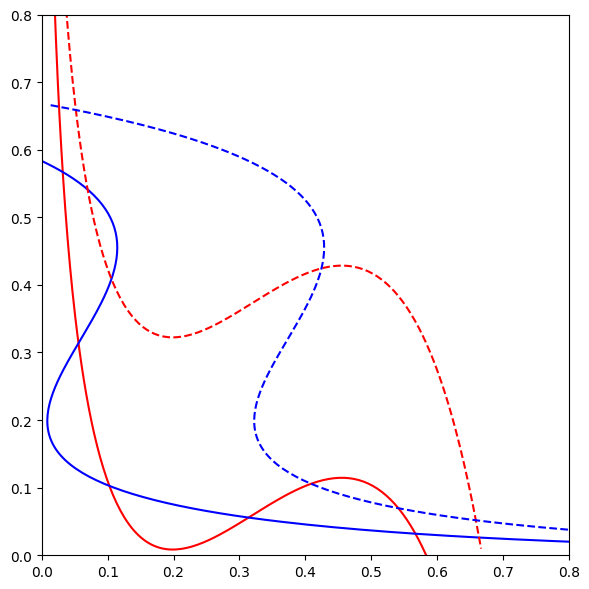

In [9]:
p = default_params()

print(p['JI'])

I1 = np.linspace(0, 1, 1000)
I2 = np.linspace(0, 1, 1000)
s1_1, s2_1= Nullcline_S1(p, I1, ifstim = False, fixed_range=True)
s1_2, s2_2 = Nullcline_S2(p, I2, ifstim = False, fixed_range=True)
s1_1_stim, s2_1_stim = Nullcline_S1(p, I1, ifstim = True, fixed_range=True)
s1_2_stim, s2_2_stim = Nullcline_S2(p, I2, ifstim = True, fixed_range=True)

fig, axs = plt.subplots(figsize = (6,6),sharex = True, sharey = True, dpi = 100)
axs.plot(s1_1, s2_1, 'r', label = "S1 nullcline")
axs.plot(s1_2, s2_2, 'b', label = "S2 nullcline")
axs.plot(s1_1_stim, s2_1_stim, 'r', ls = '--', label = "S1 nullcline")
axs.plot(s1_2_stim, s2_2_stim, 'b', ls = '--', label = "S2 nullcline")

plt.xlim([0, 0.8])
plt.ylim([0, 0.8])
#plt.legend()
plt.tight_layout()
plt.savefig("plots/wongwangattractors.png")

# Changing cross inhibition

In [ ]:
def Modified_Nullcline_S1(pars, I1, fixed_range=True, ifstim = True):
    """
    Obtain nullcline S1 from equation (3)
    """
    a, b, d = pars['a'], pars['b'], pars['d']
    JE, JI = pars['JE'], pars['JI']
    gamma, tauS = pars['gamma'], pars['tauS']
    Jext, mu0, Ib1 = pars['Jext'], pars['mu0'], pars['Ib1']
    Istim = ifstim*(Jext*mu0)*(1 - p['coh']/100)
    
    S1 = gamma*F(I1, a, b, d) / (gamma*F(I1, a, b, d) + 1./tauS)
    S2 = (I1 - JE*S1 - Ib1 - Istim) / JI
    if fixed_range:
        id_range = (S2>=-0.0) &(S2<=1.2)
    else:
        id_range = S2<=1e5
    
    return S1[id_range], S2[id_range]